In [706]:
import glob
import numpy as np
import matplotlib.pyplot as plt

# Mixtures of Gaussians to distinguish apple vs. non-apple
Use mixtures of Gaussians to distinguish apple vs. non-apple pixels. Use red, green, and blue as your dimensions for now. Make any other decisions you need to, and document them in your .ipynb notebook.

***getMixGaussLogLike()***  
Modified based on praticalC, with higher computing speed. Cancelling the loop for nData and using transpose to get diagonal elements.

In [707]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for i in range(mixGaussEst['k']):
        weight = mixGaussEst['weight'][i]
        mu = mixGaussEst['mean'][:, i][:, np.newaxis]
        cov = mixGaussEst['cov'][:,:,i]
        prob = (1 / ((2*np.pi)**(nDims/2) * np.sqrt(np.linalg.det(cov))))
        prob *= np.exp(np.sum((-0.5 * (data - mu).T @ np.linalg.inv(cov)) * (data - mu).T, axis=1))
        logLike += prob * weight
    logLike = np.sum(np.log(logLike))                                                            
                                                                                                       
    return  logLike.item()       

***fitMixGauss()***  
Modified the postHidden calculation based on praticalC, with higher computing speed. Cancelling the loop for nData and using transpose to get diagonal elements.

In [708]:
def fitMixGauss(data, k, nIter=30):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.random.randn(nDims, nDims, k)
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
    # TO DO - fill in this routine
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        # for cData in range(nData):
        #     # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
        #     # this data point came from each of the Gaussians
        #     # replace this:
        #     thisData = data[:, cData]
        #     l = np.zeros((k, nData))
        #     for i in range(k):
        #         weight = mixGaussEst['weight'][i]
        #         mu = mixGaussEst['mean'][:, i]
        #         cov = mixGaussEst['cov'][:,:,i]
        #         prob = (1 / ((2*np.pi)**(nDims/2) * np.sqrt(np.linalg.det(cov))) * 
        #                 np.exp(-0.5 * (thisData - mu).T @ np.linalg.inv(cov) @ (thisData - mu)))
        #         l[i][cData] = weight * prob
        #     postHidden[:, cData] = l[:, cData] / np.sum(l[:, cData])

        for i in range(k):
            weight = mixGaussEst['weight'][i]
            mu = mixGaussEst['mean'][:, i][:, np.newaxis]
            cov = mixGaussEst['cov'][:,:,i]
            prob = (1 / ((2*np.pi)**(nDims/2) * np.sqrt(np.linalg.det(cov))))
            prob *= np.exp(np.sum((-0.5 * (data - mu).T @ np.linalg.inv(cov)) * (data - mu).T, axis=1))
            postHidden[i, :] = prob * weight
        postHidden = postHidden / np.sum(postHidden, axis=0)
            

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :]) / np.sum(postHidden)
            
            
            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:,cGauss] = np.sum(data * postHidden[cGauss], axis=1) / np.sum(postHidden[cGauss, :])
            
            
            # TO DO (j):  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            mean = mixGaussEst['mean'][:,cGauss][:, np.newaxis]
            tmp = ((data - mean) * postHidden[cGauss, :]) @ (data - mean).T
            mixGaussEst['cov'][:,:,cGauss] = tmp / np.sum(postHidden[cGauss, :]) + np.eye(nDims) * 10e-6

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

***Load train image and mask***  
Get the first channel as binary mask

In [709]:
rgb_train_files = glob.glob("apples/apples/*.jpg")
ColorImgs = []
for myFile in rgb_train_files:
    im = plt.imread(myFile)
    ColorImgs.append(im)

mask_train_files = glob.glob("apples/apples/*.png")
MaskImgs = []
for myFile in mask_train_files:
    im = plt.imread(myFile)
    MaskImgs.append(im[:,:,0])

***Data preprocessing***  
Make apple and nonApple data by using indexes in mask images.  
Transpose the data to (nDim, nData) for fitMixGauss() to process.  
Nomalize the data to avoid -inv loglikelihood.

In [710]:
Apple_data = []
nonApple_data = []
for idx in range(len(ColorImgs)):
    H, W , C= ColorImgs[idx].shape
    Apple_data.append(ColorImgs[idx][np.where(MaskImgs[idx] == 1)].reshape((-1, C)).T / 255.)
    nonApple_data.append(ColorImgs[idx][np.where(MaskImgs[idx] == 0)].reshape((-1, C)).T / 255.)
Apple_data = np.hstack(tuple(Apple_data))
nonApple_data = np.hstack(tuple(nonApple_data))

In [711]:
k_1 = 5
nIter_1 = 100
mixGaussEst_apple = fitMixGauss(Apple_data, k_1, nIter=nIter_1)

Log Likelihood Iter 0 : -2220964.376



Log Likelihood After Iter 0 : 289771.694

Log Likelihood After Iter 1 : 307507.474

Log Likelihood After Iter 2 : 354471.020

Log Likelihood After Iter 3 : 436217.293

Log Likelihood After Iter 4 : 518750.983

Log Likelihood After Iter 5 : 586602.622

Log Likelihood After Iter 6 : 664595.301

Log Likelihood After Iter 7 : 720348.835

Log Likelihood After Iter 8 : 740095.211

Log Likelihood After Iter 9 : 749971.512

Log Likelihood After Iter 10 : 759533.893

Log Likelihood After Iter 11 : 770304.270

Log Likelihood After Iter 12 : 781105.210

Log Likelihood After Iter 13 : 791008.898

Log Likelihood After Iter 14 : 799780.799

Log Likelihood After Iter 15 : 807239.510

Log Likelihood After Iter 16 : 813452.384

Log Likelihood After Iter 17 : 818840.145

Log Likelihood After Iter 18 : 823939.768

Log Likelihood After Iter 19 : 829067.020

Log Likelihood After Iter 20 : 834220.361

Log Likelihood After Iter 21 : 839204.966

Log Likelihood After Iter 22 : 843732.778

Log Likelihood After 

In [712]:
k_2 = 15
nIter_2 = 100
mixGaussEst_nonApple = fitMixGauss(nonApple_data, k_2, nIter=nIter_2)

Log Likelihood Iter 0 : -2722452.811

Log Likelihood After Iter 0 : 430816.303

Log Likelihood After Iter 1 : 490048.549

Log Likelihood After Iter 2 : 554655.157

Log Likelihood After Iter 3 : 610574.666

Log Likelihood After Iter 4 : 648002.547

Log Likelihood After Iter 5 : 673819.882

Log Likelihood After Iter 6 : 694198.480

Log Likelihood After Iter 7 : 716696.812

Log Likelihood After Iter 8 : 762383.048

Log Likelihood After Iter 9 : 851844.657

Log Likelihood After Iter 10 : 893945.900

Log Likelihood After Iter 11 : 915891.493

Log Likelihood After Iter 12 : 928715.441

Log Likelihood After Iter 13 : 937729.840

Log Likelihood After Iter 14 : 944932.556

Log Likelihood After Iter 15 : 951167.954

Log Likelihood After Iter 16 : 957237.518

Log Likelihood After Iter 17 : 963366.130

Log Likelihood After Iter 18 : 969352.810

Log Likelihood After Iter 19 : 974772.080

Log Likelihood After Iter 20 : 979216.482

Log Likelihood After Iter 21 : 982584.602

Log Likelihood After Iter 

# Test on testApples
Download the file testApples.zip. Generate figures for your notebook, showing each pixel’s posterior probability of being “apple.” Comment on the outcomes.

***getMixGaussProb()***  
Get mix Gaussian probs from one image.

In [713]:
def getMixGaussProb(data, mixGaussEst):
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    like = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for i in range(mixGaussEst['k']):
        weight = mixGaussEst['weight'][i]
        mu = mixGaussEst['mean'][:, i][:, np.newaxis]
        cov = mixGaussEst['cov'][:,:,i]
        prob = (1 / ((2*np.pi)**(nDims/2) * np.sqrt(np.linalg.det(cov))))
        prob *= np.exp(np.sum((-0.5 * (data - mu).T @ np.linalg.inv(cov)) * (data - mu).T, axis=1))
        like += prob * weight                                                      
                                                                                                       
    return  like

In [714]:
rgb_test_files = glob.glob("testApples/*.jpg")
testColorImgs = []
for myFile in rgb_test_files:
    im = plt.imread(myFile)
    testColorImgs.append(im)

***Prior Parameters***  
These two parameters come from masks. prior_apple means the proportion of 1 in masks and prior_nonApple means 0 in masks.

In [715]:
prior_apple = 0.53
prior_nonApple = 0.47

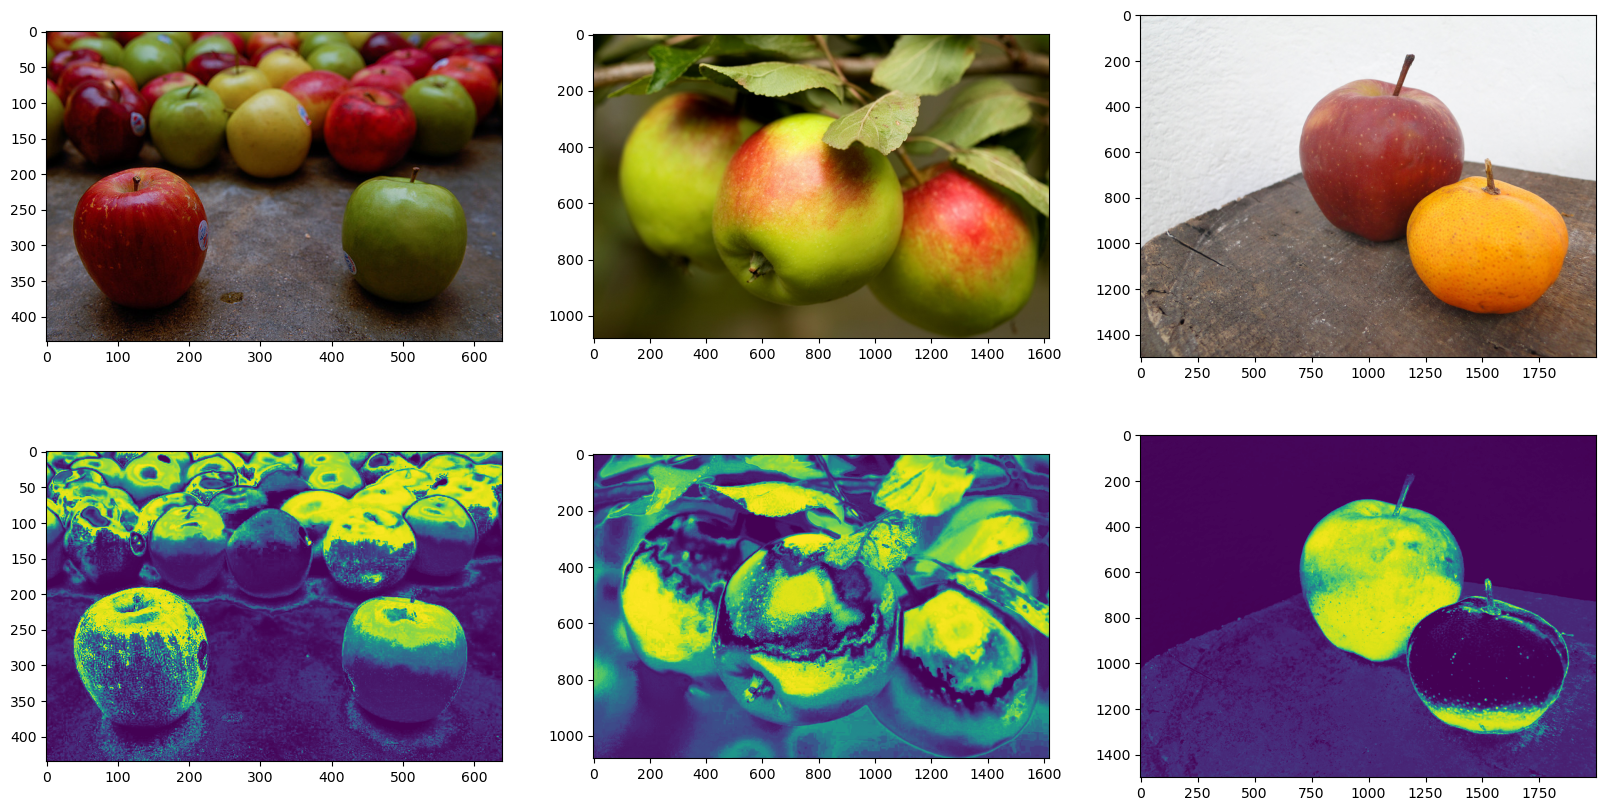

In [716]:
plt.figure(figsize=(20, 10))
for idx in range(len(rgb_test_files)):
    plt.subplot(2, 3, idx + 1)
    plt.imshow(testColorImgs[idx])
probs_apple = []
probs_nonApple = []
postpriors = []
for idx in range(len(rgb_test_files)):
    H, W, C = testColorImgs[idx].shape
    testData = testColorImgs[idx].reshape((-1, C)).T / 255.
    prob_apple = getMixGaussProb(testData, mixGaussEst_apple)
    prob_apple = np.array(prob_apple).reshape((H, W))
    probs_apple.append(prob_apple)
    prob_nonApple = getMixGaussProb(testData, mixGaussEst_nonApple)
    prob_nonApple = np.array(prob_nonApple).reshape((H, W))
    probs_nonApple.append(prob_nonApple)
    prob_postprior = prob_apple * prior_apple / (prob_apple * prior_apple + prob_nonApple * prior_nonApple)
    postpriors.append(prob_postprior)
    plt.subplot(2, 3, 4 + idx)
    plt.imshow(prob_postprior)

***Explanation***  
The first row of figures are original apple pictures and the second row of figures are posterior probs for each picture.  
Bright red, dark red and bright green have high posterior while shadows and backings have low posterior.  
The second test picture has high posterior on green leaves because they have similar color to green apples.  
The third test pecture has high posterior on the bottom of the orange because it looks like red.

# Implement thresholds, display confusion matrix & ROC curve.
For the test image with a ground-truth mask, quantify and report your result. Hint: consider applying a range of thresholds to the posterior to produce sets of{True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)} and using an ROC curve.

In [717]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred, ax):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    return [tp, tn, fp, fn]

In [718]:
test_mask = plt.imread('testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.png')[:, :, 0].squeeze()
threshold_num = 11
thresholds = np.linspace(0, 1, threshold_num)
test_results = []
for threshold in thresholds:
    test_result = probs_apple[2] * prior_apple / (probs_apple[2] * prior_apple + probs_nonApple[2] * prior_nonApple)
    test_result[test_result >= threshold] = 1
    test_result[test_result < threshold] = 0
    test_results.append(test_result)

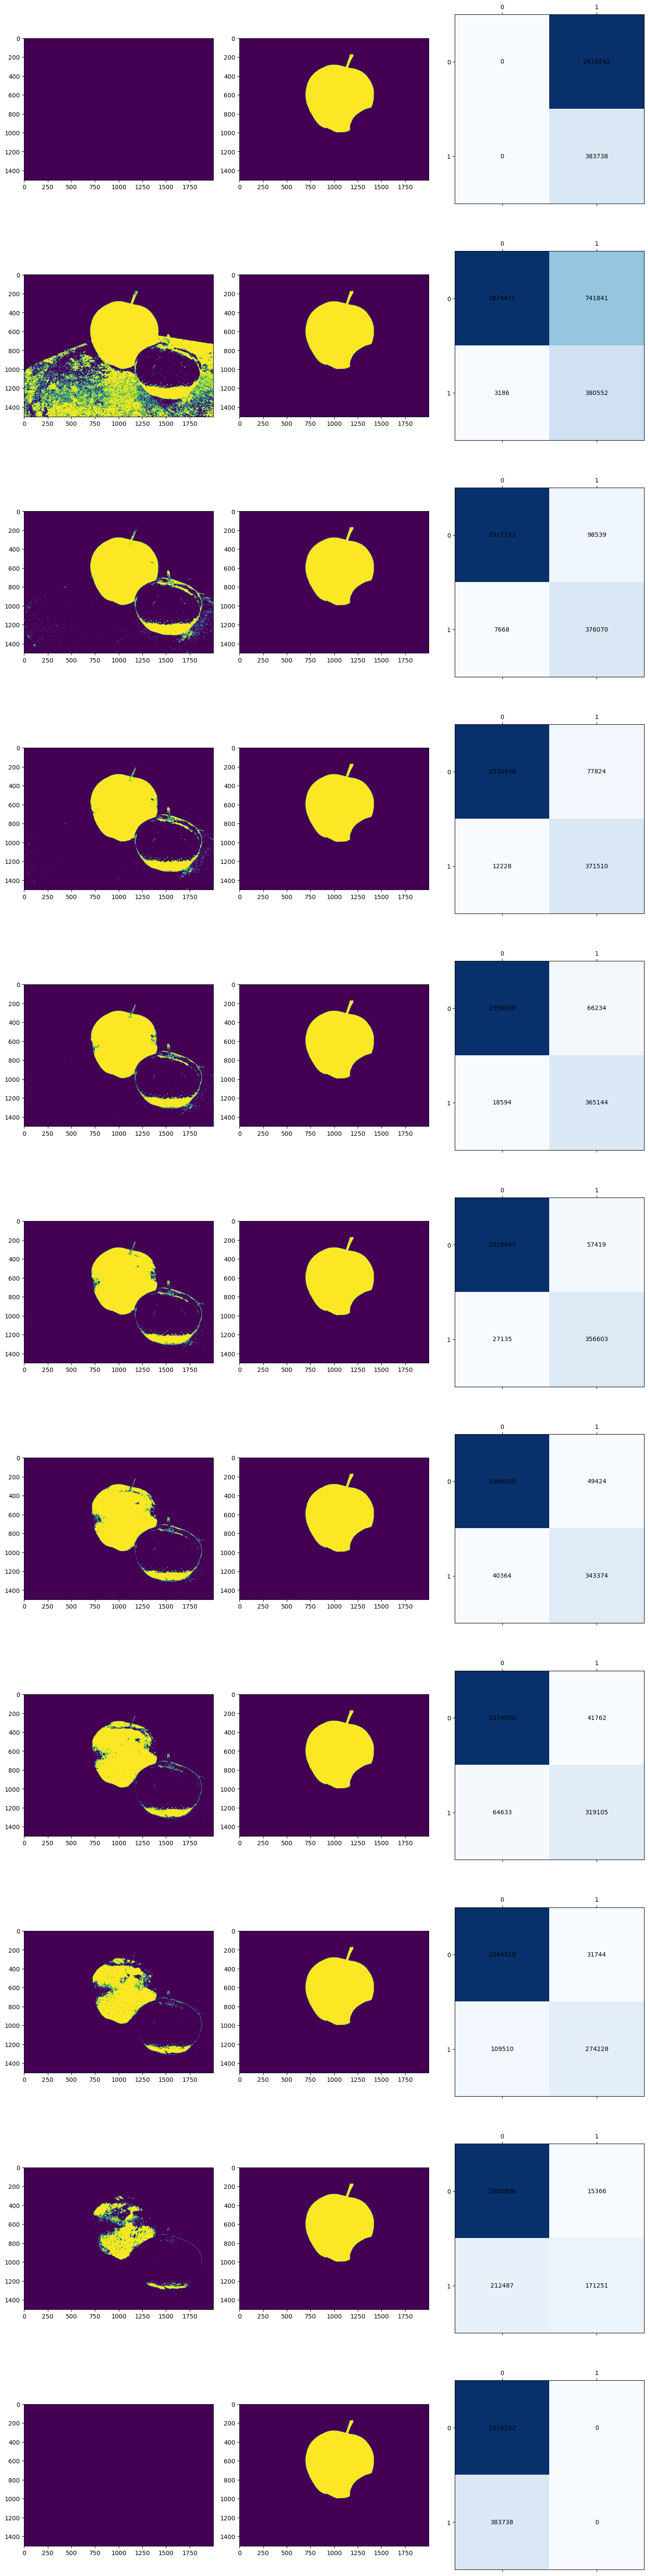

Accuracy on 0.5 threshold: 0.9718153333333334


In [719]:
fig, axs = plt.subplots(threshold_num, 3, figsize=(15,60))
TPR = []
FPR = []
Acc = []
for i in range(threshold_num):
    axs[i][0].imshow(test_results[i])
    axs[i][1].imshow(test_mask)
    tp, tn, fp, fn = plot_confusion_matrix(test_mask.flatten(), test_results[i].flatten(), axs[i][2])
    TPR.append(tp / (tp + fn))
    FPR.append(fp / (fp + tn))
    Acc.append((tp + tn) / (tp + tn + fp + fn))
fig.tight_layout()
plt.show()
print('Accuracy on 0.5 threshold: ' + str(Acc[5]))

***Explanation***  
Above 20 figures display the posterior with different thresholds, ground truth and confusion matrixes.  
When threshold equals 0.5, the result is quite good, with about 97.19% accuracy.

Text(0.5, 1.0, 'ROC curve on 3rd test image')

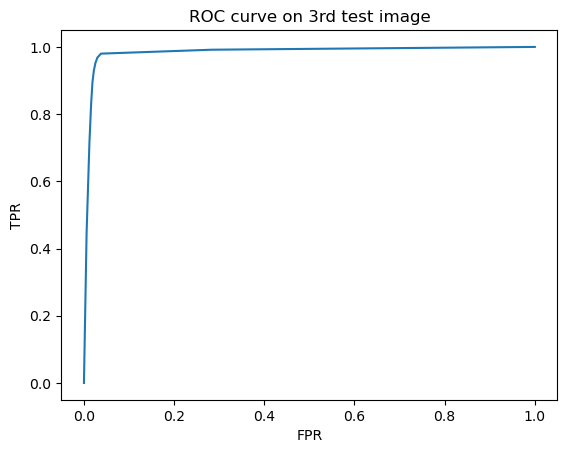

In [720]:
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve on 3rd test image')

***Explanation***  
The ROC curve for the second test image is quite good because the curve is closer to the upper left and far away from the diagonal.  
So the curve is sensitive and specific.  

# Test on two non-copyrighted photos
Download or snap two non-copyrighted photos with apples (maybe http://search.creativecommons.org/ or some other source of images that are not copyrighted). Make good ground-truth masks for them. You can use Windows Paint, or more sophisticated programs like Gimp (free). Use these as extra test-images. Report your qualitative and quantitative results.

In [721]:
test_1 = plt.imread('test_1.jpg')
test_2 = plt.imread('test_2.jpg')
mask_1 = plt.imread('mask_1.png')[:, :, 0]
mask_2 = plt.imread('mask_2.png')[:, :, 0]
mask_1[mask_1 != 0] = 1
mask_2[mask_2 != 0] = 1

In [722]:
test_data_1 = test_1.reshape((-1, 3)).T / 255.
test_data_2 = test_2.reshape((-1, 3)).T / 255.
test_prob_apple_1 = getMixGaussProb(test_data_1, mixGaussEst_apple).reshape(test_1.shape[:2])
test_prob_nonApple_1 = getMixGaussProb(test_data_1, mixGaussEst_nonApple).reshape(test_1.shape[:2])
test_prob_apple_2 = getMixGaussProb(test_data_2, mixGaussEst_apple).reshape(test_2.shape[:2])
test_prob_nonApple_2 = getMixGaussProb(test_data_2, mixGaussEst_nonApple).reshape(test_2.shape[:2])
test_posterior_1 = test_prob_apple_1 * prior_apple / (test_prob_apple_1 * prior_apple + test_prob_nonApple_1 * prior_nonApple)
test_posterior_2 = test_prob_apple_2 * prior_apple / (test_prob_apple_2 * prior_apple + test_prob_nonApple_2 * prior_nonApple)

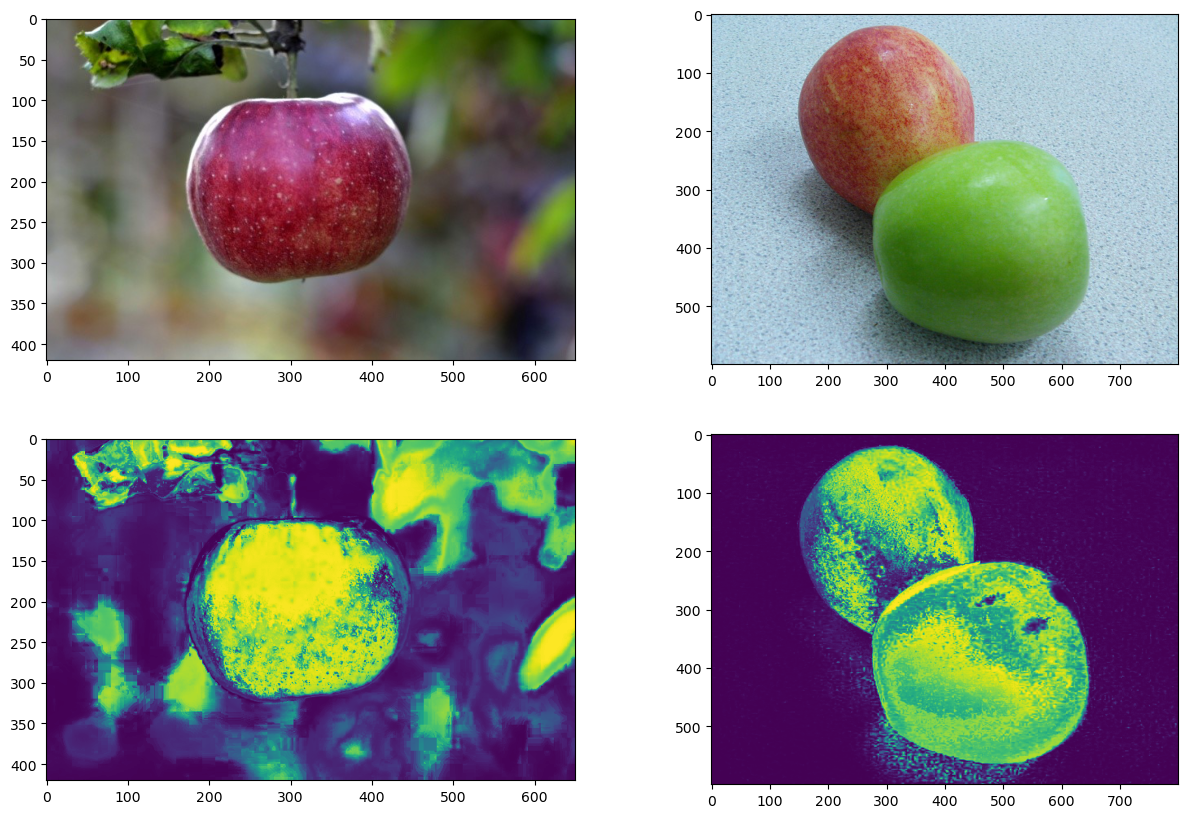

In [723]:
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.imshow(test_1)
plt.subplot(2, 2, 2)
plt.imshow(test_2)
plt.subplot(2, 2, 3)
plt.imshow(test_posterior_1)
plt.subplot(2, 2, 4)
plt.imshow(test_posterior_2)

***Explanation***  
The original picture and posterior results of two extra test images.  
Many green elements on the background also have high posterior because there are many green apples in training images.  

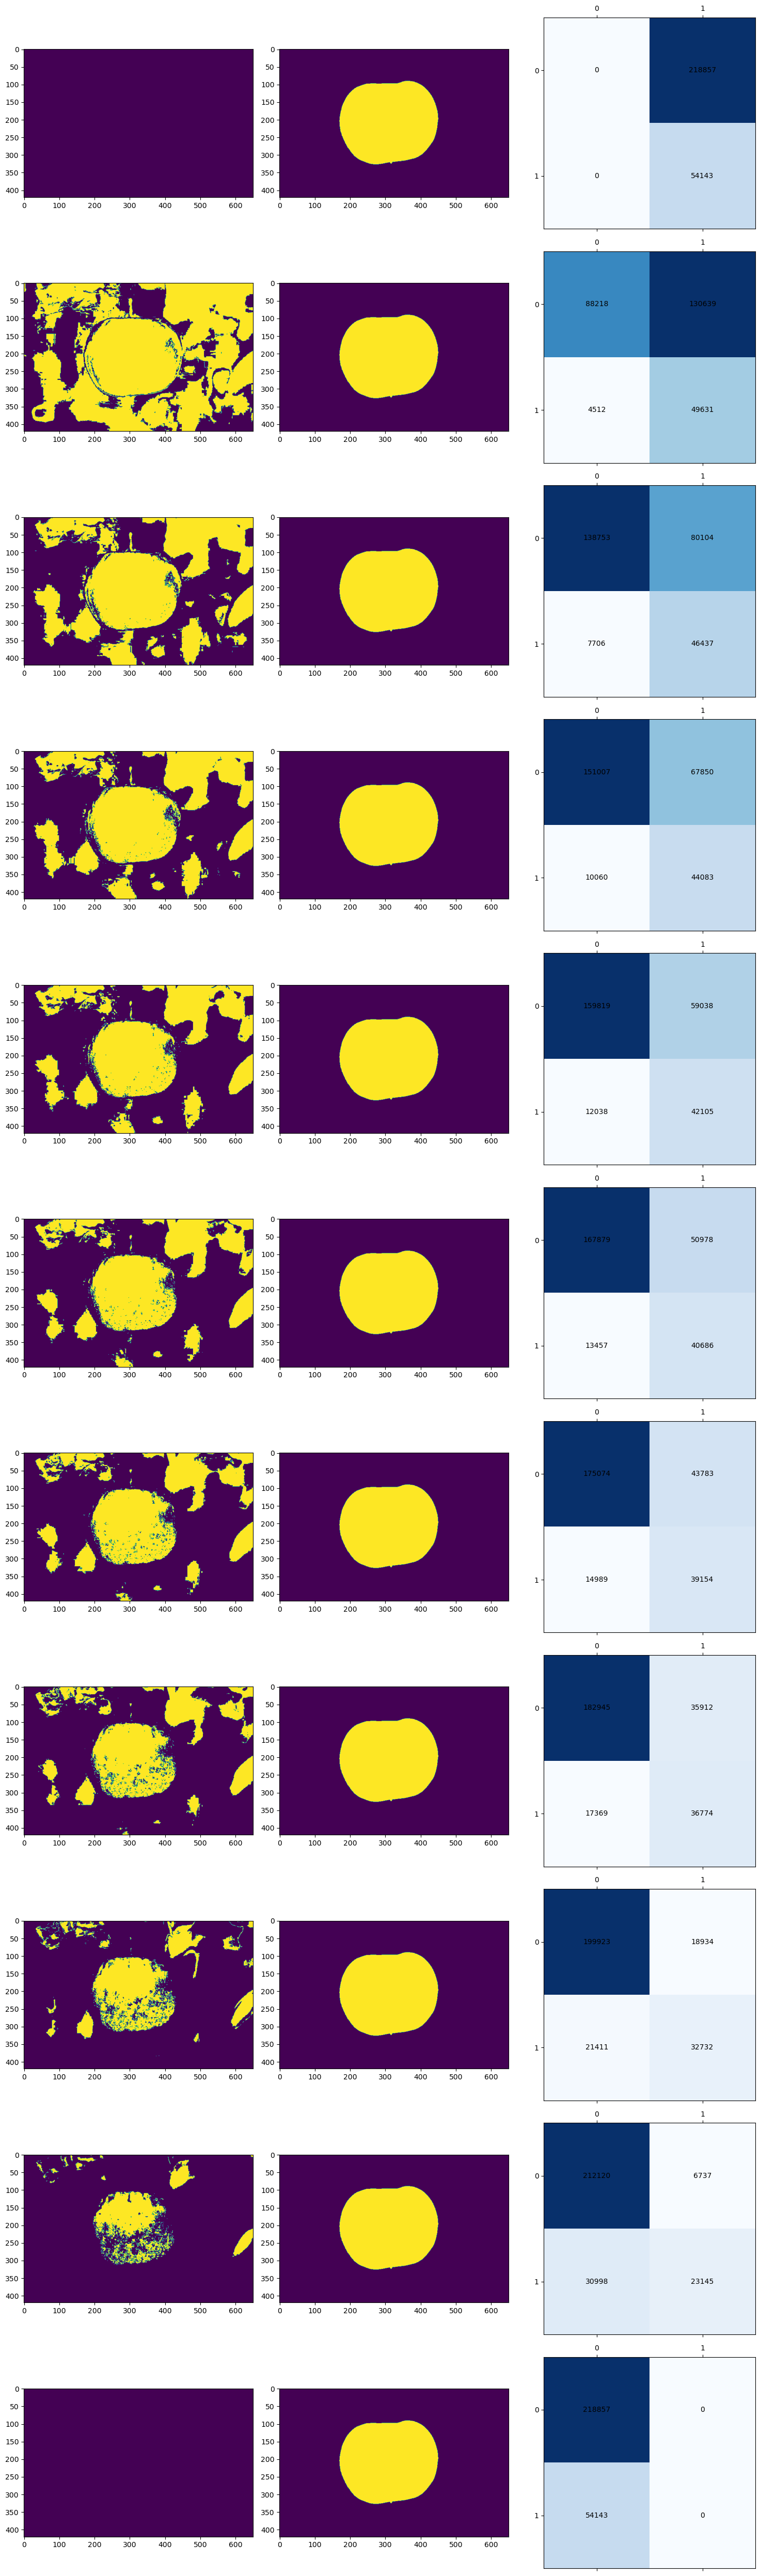

Accuracy on 0.5 threshold: 0.763974358974359


In [724]:
threshold_num = 11
thresholds = np.linspace(0, 1, threshold_num)
test_results_1 = []
TPR = []
FPR = []
Acc = []
for threshold in thresholds:
    test_result = test_posterior_1.copy()
    test_result[test_result >= threshold] = 1
    test_result[test_result < threshold] = 0
    test_results_1.append(test_result)

fig, axs = plt.subplots(threshold_num, 3, figsize=(15,50))
for i in range(threshold_num):
    axs[i][0].imshow(test_results_1[i])
    axs[i][1].imshow(mask_1)
    tp, tn, fp, fn = plot_confusion_matrix(mask_1.flatten(), test_results_1[i].flatten(), axs[i][2])
    TPR.append(tp / (tp + fn))
    FPR.append(fp / (fp + tn))
    Acc.append((tp + tn) / (tp + tn + fp + fn))
fig.tight_layout()
plt.show()

print('Accuracy on 0.5 threshold: ' + str(Acc[5]))

***Explanation***  
Above 10 figures display the posterior of the first extra test image with different thresholds, ground truth and confusion matrixes.  
When threshold equals 0.5, with about 76.40% accuracy.

Text(0.5, 1.0, 'ROC curve on 3rd test image')

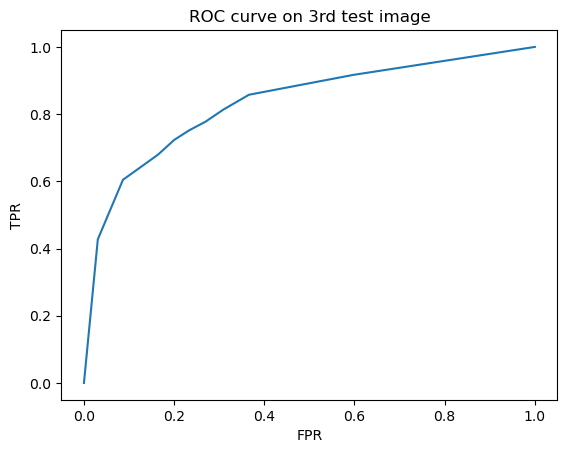

In [725]:
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve on 3rd test image')

***Explanation***  
The ROC curve for the first extra test image, which is worse to ROC curves of test images.

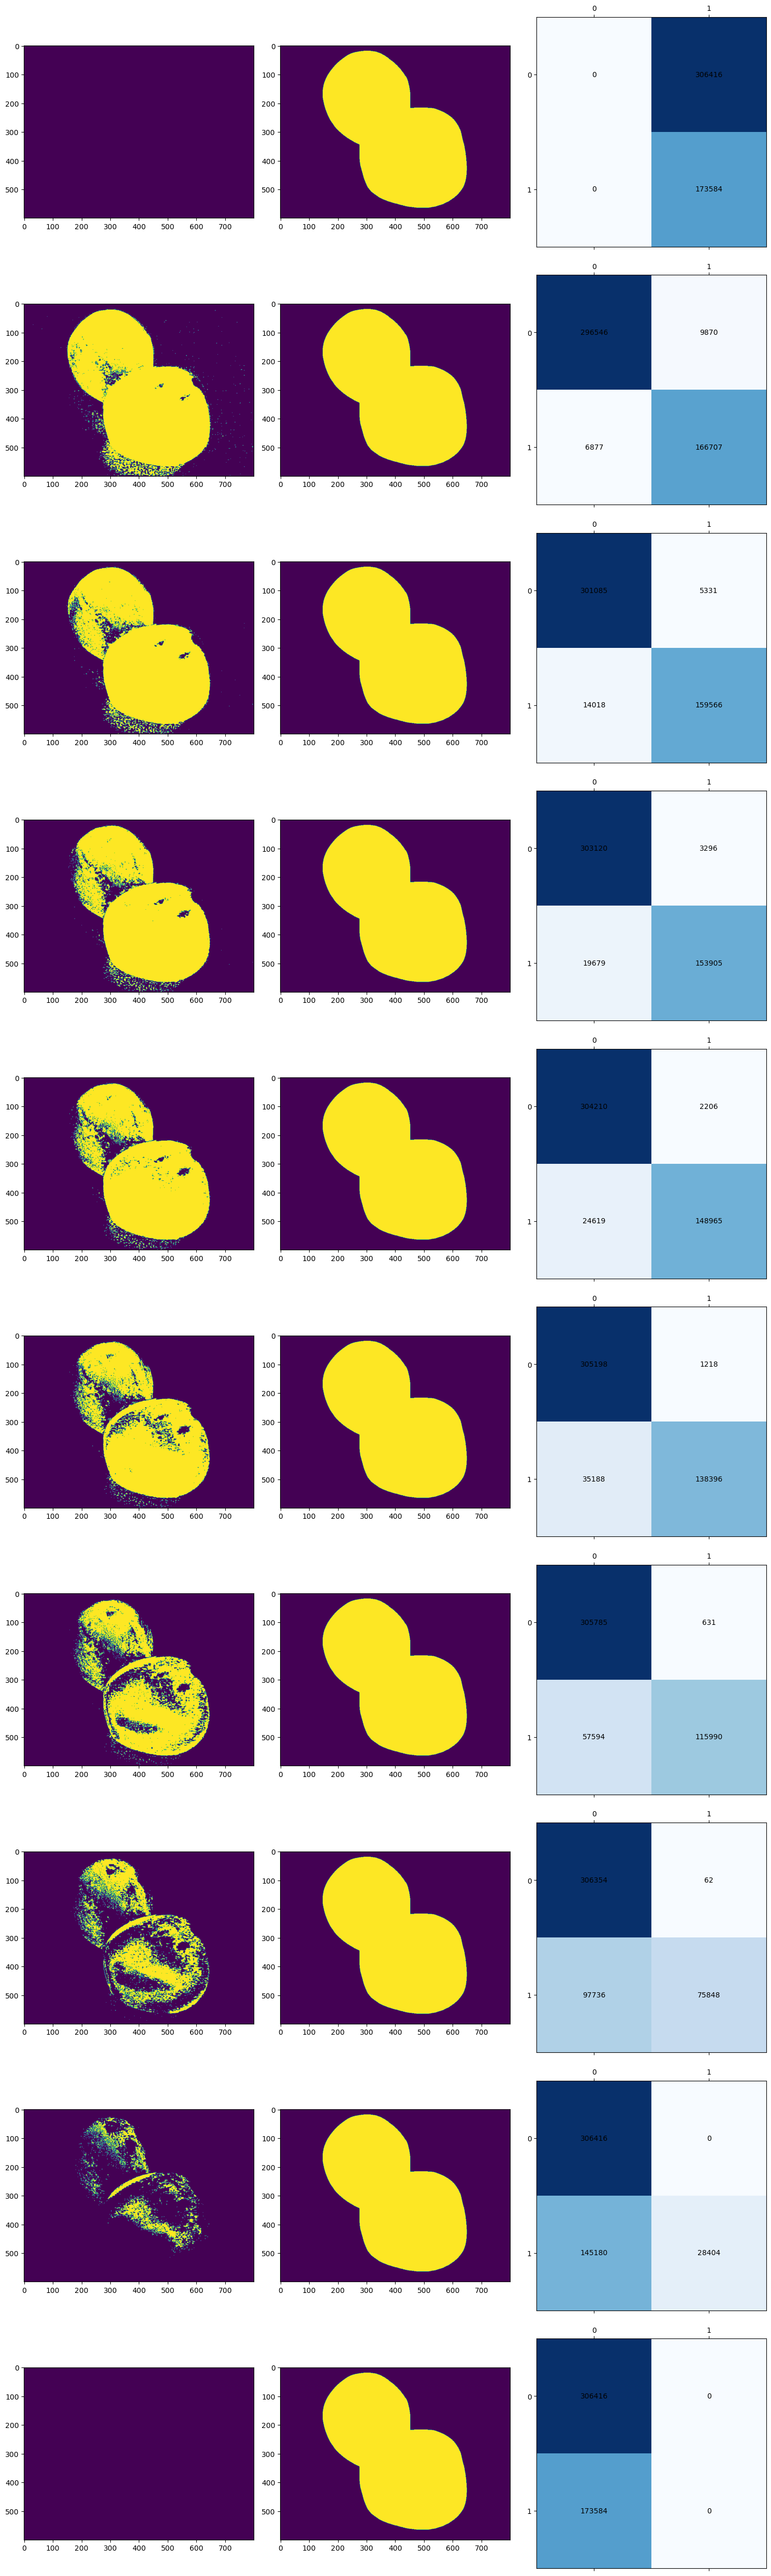

Accuracy on 0.5 threshold: 0.9241541666666667


In [726]:
threshold_num = 10
thresholds = np.linspace(0, 1, threshold_num)
test_results_2 = []
TPR = []
FPR = []
Acc = []
for threshold in thresholds:
    test_result = test_posterior_2.copy()
    test_result[test_result >= threshold] = 1
    test_result[test_result < threshold] = 0
    test_results_2.append(test_result)

fig, axs = plt.subplots(threshold_num, 3, figsize=(15,50))
for i in range(threshold_num):
    axs[i][0].imshow(test_results_2[i])
    axs[i][1].imshow(mask_2)
    tp, tn, fp, fn = plot_confusion_matrix(mask_2.flatten(), test_results_2[i].flatten(), axs[i][2])
    TPR.append(tp / (tp + fn))
    FPR.append(fp / (fp + tn))
    Acc.append((tp + tn) / (tp + tn + fp + fn))
fig.tight_layout()
plt.show()

print('Accuracy on 0.5 threshold: ' + str(Acc[5]))

***Explanation***  
Above 10 figures display the posterior of the second extra test image with different thresholds, ground truth and confusion matrixes.  
When threshold equals 0.5, accuracy is around 92.41%.  
Both red apple and green apple have high posterior, well fitting to the traing data.

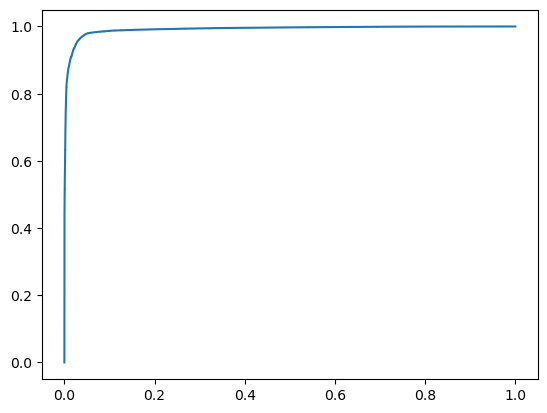

In [727]:
fpr, tpr, thre = roc_curve(mask_2.flatten(), test_posterior_2.copy().flatten())
plt.plot(fpr, tpr)

***Explanation***  
The ROC curve for the second extra test image, which is worse to ROC curves of test images.

## We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why.

Training Set: Model will learn on this set to update weights and hidden parameters.  
Validation Set: We can evaluate the performance of the model by testing on the validation set. Then we can find out whether the model is overfitting and fine tune hyper parameters. When a model overfits, it performs well on training data but fails on new data. We can also select the model that performs well on the validation set.  
Test Set: When the model is well trained, we need to test the model on an indepedent and new dataset.